## Replication of Keller et al. (2026) on the TRAPPIST-1 Case
A study on how higher-order resonances can form in just Type I migration.

#### Imports and Units

In [306]:
import re
import rebound
import reboundx
import numpy as np
import pandas as pd
import pickle
import scipy
import matplotlib.pyplot as plt
from time import time
from astropy import constants as const
from astropy import units as u
from labellines import labelLines
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    
Msun = u.Msun.to(u.g) 
yr = u.yr.to(u.s)    
r_earth = u.earthRad.to(u.AU)
m_earth = u.Mearth.to(u.Msun)
r_sun = u.Rsun.to(u.AU) 

#### Randomly generate mass, radius, & semimajor axis values
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [307]:
def parse_entry(entry):
    """
    Parses strings of form:
        '1.0±0.01'
        '1.04 +0.01 -0.02'
    
    Returns:
        mu (float), sigma (float)
    """
    
    if pd.isna(entry):
        raise ValueError("Entry is NaN")
    
    # Remove extra whitespace
    entry = entry.strip()
    
    # Remove spaces for easier parsing
    entry_nospace = entry.replace(" ", "")
    
    # Case 1: symmetric uncertainty (±)
    match_pm = re.match(r"^([0-9.+\-eE]+)±([0-9.+\-eE]+)$", entry_nospace)
    if match_pm:
        mu = float(match_pm.group(1))
        sigma = float(match_pm.group(2))
        return mu, sigma
    
    # Case 2: asymmetric uncertainty (+x -y)
    match_asym = re.match(
        r"^([0-9.+\-eE]+)\+([0-9.+\-eE]+)\-([0-9.+\-eE]+)$",
        entry_nospace
    )
    if match_asym:
        mu = float(match_asym.group(1))
        sigma_plus = float(match_asym.group(2))
        sigma_minus = float(match_asym.group(3))
        
        # Convert asymmetric → effective symmetric σ
        sigma = 0.5 * (sigma_plus + sigma_minus)
        
        return mu, sigma
    
    raise ValueError(f"Could not parse entry: {entry}")

def generate_params(csv_file, params, n_samples=1):
    """
    Reads planet parameter CSV and returns Monte Carlo samples
    for mass, radius, and semimajor axis.
    """
    
    df = pd.read_csv(csv_file)
    
    # Set index to Source column for easy lookup
    df = df.set_index("Source")
    
    # Extract Agol et al. 2021 column
    col = "Agol et al. 2021"
    
    params_dict = {}
    
    for param in params:
        # Parse parameter
        mu, sigma = parse_entry(df.loc[param, col])
    
        # Draw Gaussian samples
        samples  = np.random.normal(mu, sigma, n_samples)

        # Add to dict
        params_dict[param] = samples
    
    return params_dict

planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']

# Nested dict containing params for each planet in sim
planet_params = {f"{planet_name}": generate_params(f'TRAPPIST-1_params/TRAPPIST-1_{planet_name}_planet_params.csv', ('a (au)', 'Rp (R⨁)', 'Mp (M⨁)')) for planet_name in planet_names}
stellar_params = generate_params('TRAPPIST-1_params/TRAPPIST-1_stellar_params.csv', ('R✶ (R⦿)', 'M✶ (M⦿)'))

#### Sim Setup

In [308]:
# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
m_star = stellar_params['M✶ (M⦿)']
r_star = stellar_params['R✶ (R⦿)'] * r_sun
sim.add(m=m_star, r=r_star)

num_planets = len(planet_names)

# Define planet masses (m)
m_vals = np.array([planet_params[planet_name]['Mp (M⨁)'] for planet_name in planet_names])
m_vals *= m_earth # convert to Msun

# Define planet radii (r)
r_vals = np.array([planet_params[planet_name]['Rp (R⨁)'] for planet_name in planet_names])
r_vals *= r_earth # convert to AU

# Define initial eccentricities (e)
e_vals = np.zeros_like(m_vals)

# Draw initial mean anomalies (M)
M_vals = np.random.uniform(0, 2*np.pi, size=num_planets)

# Initial semimajor axis of b
a_b = 0.05

# Draw initial ratios from log normal
initial_P_ratios = np.random.lognormal(0.45, 0.1, size=num_planets-1) 
                                     # In Keller, 0.703 & 0.313

# Define initial periods (P) and semimajor axes (a)
P_vals = (a_b**3 / m_star)**(1/2)
for i in range(num_planets-1):
    P_vals = np.append(P_vals, P_vals[i] * initial_P_ratios[i])
    
a_vals = (P_vals**2 * m_star)**(1/3)

print("Initial period ratios:")
print(np.round(initial_P_ratios, decimals=4))
print("\nInitial period values (yr):")
print(np.round(P_vals, decimals=4))
print("\nInitial semimajor axis values (AU):")
print(np.round(a_vals, decimals=4))

# Add planets 
for i in range(num_planets):
    sim.add(m=m_vals[i], r=r_vals[i], a=a_vals[i], e=e_vals[i], M=M_vals[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

Initial period ratios:
[1.8502 1.4814 1.5565 1.7786 1.6683 1.46  ]

Initial period values (yr):
[0.0369 0.0683 0.1011 0.1574 0.2799 0.467  0.6819]

Initial semimajor axis values (AU):
[0.05   0.0754 0.0979 0.1315 0.1931 0.2716 0.3495]


#### Sim Params
Based on section 2.1 in Keller et al. (2026).

In [309]:
def get_taus(a_vals, m_vals, M_star, h, Sigma, alpha=1.5):
    '''
    Computes damping timescales based on current semimajor axis values.
    
    Parameters:
        a_vals: 1D NumPy array of current semimajor axis values.
    
    Returns:
        tau_a: semimajor axis damping timescale.
        tau_e: eccentricity damping timescale.
    '''
    tau_a = (1/(2.7+1.1*alpha)) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**2 / np.sqrt(const.G.value*M_star/a_vals**3))
    tau_e = (1/0.780) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**4 / np.sqrt(const.G.value*M_star/a_vals**3))
    return tau_a, tau_e

def get_Sigma(a_vals, Sigma_1au, alpha=1.5):
    return Sigma_1au * a_vals**(-alpha)

def get_h(K, alpha=1.5):
    return np.sqrt(0.780/(2.7+1.1*alpha)/K)

def get_Sigma(Sigma_1au, a_vals, alpha=1.5):
    return Sigma_1au * (a_vals**-alpha)

# Draw surface density at 1au from log uniform
Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=1000, size=1) # in g/cm^2
                             # In Keller, 10 & 10000
Sigma_1au *= AU**2 / Msun # unit conversion for sim
print(f"Sigma_1au: {float(Sigma_1au):.3e}")

# Draw K-factor from log uniform and solve for h
K = scipy.stats.loguniform.rvs(a=100, b=300, size=1)
                             # In Keller, 10 & 1000
h = get_h(K) # here, h = h_1au since there is no flaring
print(f"h_1au: {float(h):.4g}")
print(f"tau_a of b: {float(get_taus(a_b, m_vals, m_star, h, get_Sigma(Sigma_1au, a_b))[0][0]):.3e}")

Sigma_1au: 2.346e-06
h_1au: 0.04012
tau_a of b: 7.102e+09


#### Handling Close Encounters
Symplectic integrators are not designed to handle close encounters, so we discard sims where planets ventured within five mutual Hill radii of each other.

In [310]:
def get_hill_radius(m1, a1, m2, a2, M_star):
    return ((m1+m2)/(3*M_star))**1/3 * (a1+a2)/2

#### Implementing REBOUNDx forces
There are several options for the location and width of the inner disk edge (IDE).
- Keller et al. (2026) used 0.05 as the position and 0.01 as the width.
- Huang & Ormel (2022) used positions $r_c \in [0.013 - 0.030 \text{ au}]$ with width $\Delta = 2hr_c = 0.06r_c$. In particular, $r_c = 0.023$ worked best.

In [311]:
rebx = reboundx.Extras(sim)
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

mig.params["tIm_scale_height_1"] = h # = h_1au
mig.params["tIm_surface_density_1"] = Sigma_1au
mig.params["tIm_surface_density_exponent"] = 1.5 # alpha
mig.params["tIm_flaring_index"] = 0 # beta

mig.params["ide_position"] = 0.023 # inner disk edge
mig.params["ide_width"] = 2*h*mig.params["ide_position"]

#### Data storage

In [312]:
def data_df(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "P": np.zeros(n_out),
        "P_ratio": np.zeros(n_out),
        "l": np.zeros(n_out),
        "pomega": np.zeros(n_out)
    })

sim.dt = planets[0].P / 20 # 1/20 of planet b
# Initial state of simulation
sim.save_to_file('trappist1_sim.bin') 

#### It's time to integrate

In [313]:
def integrate_sim(years, start_time=0):
    '''
    Integrates a REBOUND simulation over a given number of years,
    saves the new state of the sim and returns the data as a Pandas DataFrame.
    '''
    # Set up times for integration & data collection
    n_out = int(years / 5) + 1000 # number of data points to collect
    stage_times = np.linspace(start_time, years+start_time, n_out, endpoint=False)  # all times to integrate over
    stage_data = {name : data_df(n_out, stage_times) for name in planet_names[:num_planets]}
    
    tstart = time()
    stop_sim = False
    
    for i, t in enumerate(stage_times): 
        
        sim.integrate(t)
        
        current_a_vals = np.array([p.a for p in sim.particles[1:]])
        
        for p in range(num_planets):
            name = planet_names[p]
            stage_data[name]["a"][i] = planets[p].a
            stage_data[name]["e"][i] = planets[p].e
            stage_data[name]["l"][i] = planets[p].l
            stage_data[name]["pomega"][i] = planets[p].pomega
            
            if p != num_planets-1: # don't record period ratio for last planet
                stage_data[name]["P_ratio"][i] = planets[p+1].P / planets[p].P
                                
                # Stop sim if separation within 5*r_hill
                r_hill = get_hill_radius(m_vals[p], current_a_vals[p], m_vals[p+1], current_a_vals[p+1], m_star)
                
                if np.abs(current_a_vals[p] - current_a_vals[p+1]) < 5*r_hill:
                    stop_sim = True
                    print("Close encounter")
                
            # Stop sim if planet goes into star
            if planets[p].a < 0.001:
                stop_sim = True
                print("Planet collided with star")
        
        # Prevent stop in data collection        
        if type(stage_data['b']["a"][i]) != np.float64:
            stop_sim = True
            print(f"Stopped collecting data at t={t}")
        
        if stop_sim:
            print(f"Stopped integration at t={t}")
            break
        
    if not stop_sim:
        print(f'Integrated to {(years+start_time)/1000} kyrs in {time()-tstart:.4} sec')
    else:
        print(f'Time elapsed: {time()-tstart:.4} sec')
    
    return stage_data
    
# Load simulation
# sim = rebound.Simulation("trappist1_sim.bin")
stage1_data = integrate_sim(50)
stage2_data = integrate_sim(50, 50)
stage3_data = integrate_sim(50, 100)

Integrated to 0.05 kyrs in 0.5901 sec
Integrated to 0.1 kyrs in 0.5634 sec
Integrated to 0.15 kyrs in 0.5625 sec


In [314]:
# Concatenate stage data
def concatenate_data(stages):
    if len(stages) == 1:
        return stages
    
    # Concatenate first two
    all_stage_data = {
            name: pd.concat(
                [stages[0][name], stages[1][name]],
                ignore_index=True
            )
            for name in stages[0]
        }
    
    # Concatenate the rest
    for i in range(2, len(stages)):
        next_stages = stages[i]
        all_stage_data = {
            name: pd.concat(
                [all_stage_data[name], next_stages[name]],
                ignore_index=True
            )
            for name in all_stage_data
        }
    return all_stage_data

all_data = concatenate_data((stage1_data, stage2_data, stage3_data))
print(all_data['b']['a'])

0       0.050000
1       0.049999
2       0.049999
3       0.050003
4       0.050000
          ...   
3025    0.049190
3026    0.049191
3027    0.049197
3028    0.049191
3029    0.049189
Name: a, Length: 3030, dtype: float64


#### Saving results as HDF5
Be careful not to override previous data.

In [ ]:
def save_simulation_run(stage_data,
                        sim_id,
                        filename="simulation_data.h5",
                        sim_metadata=None):
    """
    Save all planets from one simulation run into HDF5.
    
    Parameters
    ----------
    stage_data : dict
        {planet_name: DataFrame}
    sim_id : int
        Simulation ID
    sim_metadata : dict (optional)
        e.g. {"m_star": 1.0, "integrator": "ias15"}
    """
    
    with pd.HDFStore(filename, mode="a") as store:
        
        sim_group = f"/sim_{sim_id}"
        
        # Save planet list
        planet_list = list(stage_data.keys())
        store.put(f"{sim_group}/planet_list",
                  pd.Series(planet_list))
        
        # Save simulation metadata
        if sim_metadata is not None:
            store.put(f"{sim_group}/metadata",
                      pd.Series(sim_metadata))
        
        # Save each planet
        for planet_name, df in stage_data.items():
            
            key = f"{sim_group}/{planet_name}"
            store.put(key, df, format="table")
            
            # Attach attributes
            storer = store.get_storer(key)
            storer.attrs.planet_name = planet_name
            storer.attrs.sim_id = sim_id
           
def load_simulation_run(sim_id, filename="simulation_data.h5"):
    '''
    Given sim_id and filename of hdf5, returns the result (dict of dataframes)
    and the metadata (containing planet_name, sim_id, ide params, etc.)
    '''
    sim_group = f"/sim_{sim_id}"
    result = {}
    
    with pd.HDFStore(filename, mode="r") as store:
        
        planet_list = store[f"{sim_group}/planet_list"].tolist()
        
        for planet_name in planet_list:
            key = f"{sim_group}/{planet_name}"
            df = store[key]
            
            # Pull HDF5 attributes
            storer = store.get_storer(key)
            df.attrs["planet_name"] = storer.attrs.planet_name
            df.attrs["sim_id"] = storer.attrs.sim_id
            
            result[planet_name] = df
        
        metadata = store[f"{sim_group}/metadata"].to_dict()
    
    return result, metadata

In [322]:
save_simulation_run(all_data, sim_id=0, filename="simulation_data.h5", sim_metadata={
                        "m_star": m_star, 
                        "num_planets": num_planets, 
                        "ide_position": mig.params["ide_position"],
                        "ide_width": mig.params["ide_width"]
                        })

saved_sim = load_simulation_run(sim_id=0, filename="simulation_data.h5")
sim_data = saved_sim[0]
b = sim_data['b']
c = sim_data['c']
d = sim_data['d']
e = sim_data['e']
f = sim_data['f']
g = sim_data['g']
h = sim_data['h']

# Example usage
# print(saved_sim[1]['m_star'])
# print(b_data[:5])
# print(b_data['a'][:5])
# print(b_data.attrs["planet_name"])

#### Plot it!

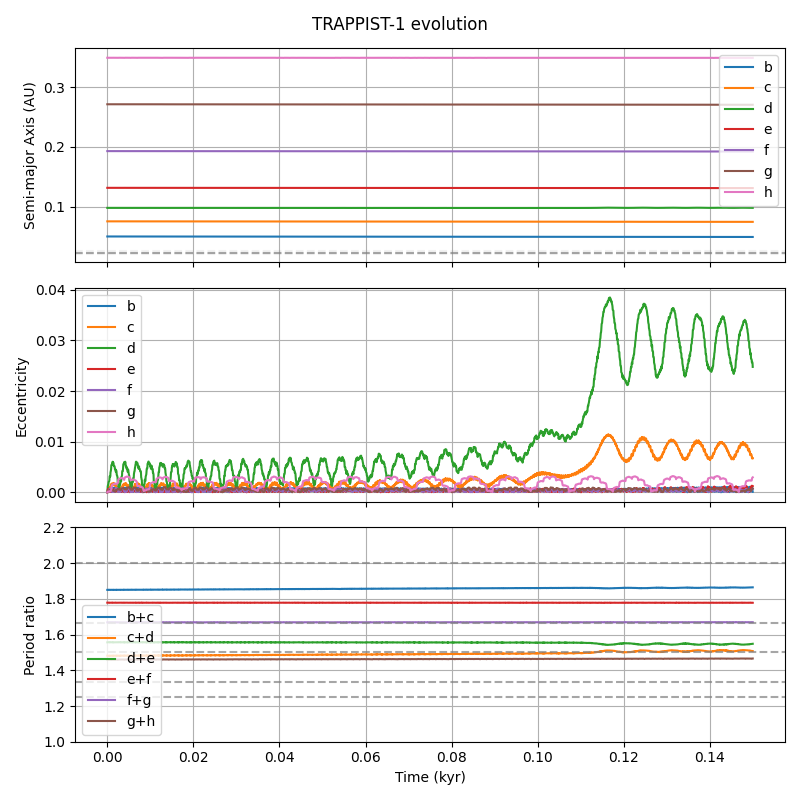

In [323]:
%matplotlib widget

def plot_trappist1(sim_data, t_units='kyr'):
    '''
    Takes dataframes for planets and plots a, e, and P ratios over time.
    '''
    times = sim_data[0]['b']['time']
    planet_names = list(sim_data[0].keys())
    num_planets = len(planet_names)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        
        if t_units == 'kyr':
            ax1.plot(times/1000, sim_data[0][name]["a"], label=name)
            ax2.plot(times/1000, sim_data[0][name]["e"], label=name)
            plt.xlabel("Time (kyr)")
    
        if p != num_planets-1:
            ax3.plot(times/1000, sim_data[0][name]["P_ratio"], label=f"{name}+{planet_names[p+1]}")
            
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period ratio")
    
    # ax1.set_ylim(0,0.45)
    # ax2.set_ylim(-0.1,0.45)
    ax3.set_ylim(1,2.2)
    
    # Plot ide location & width
    ax1.axhline(sim_data[1]["ide_position"], color='gray', ls='--', alpha=0.7)
    ax1.axhline(sim_data[1]["ide_position"] - sim_data[1]["ide_width"], color='gray', ls='--', alpha=0.1)
    ax1.axhline(sim_data[1]["ide_position"] + sim_data[1]["ide_width"], color='gray', ls='--', alpha=0.1)

    ax1.legend(); ax2.legend(); ax3.legend()
    ax1.grid(True); ax2.grid(True); ax3.grid(True)
    
    # Add horizontal lines for resonances
    resonances = [2, 3/2, 4/3, 5/3, 5/4]
    for r in resonances:
        ax3.axhline(r, color='gray', ls='--', alpha=0.7)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    plt.tight_layout(); plt.show()

plot_trappist1(saved_sim)

#### Identifying MMRs
Based on section 2.3 in Keller et al. (2026).

**Note:** Alternatively, we can use $\zeta$ given in Eq. 11 in Fabrycky et al. (2014) to determine the period ratio. As of now this $\zeta$ is for first-order MMRs only.

In [ ]:
def find_best_twoBR_pq(b, c, p_max=10, crit="Delta"):
    '''Finds the best values for p and q at the end of simulation for 
       two planets given some MMR criterion'''
    if crit == 'Delta':
        best_Delta = 100
    elif crit == 'zeta':
        best_zeta = 100
        
    best_p, best_q = 100, 100
    
    for p in range(1, p_max+1):
        for q in range(1, p):
            # Use Kepler's law to find period values
            P_b = (b['a'].iloc[-1]**3 / m_star)**(1/2)
            P_c = (c['a'].iloc[-1]**3 / m_star)**(1/2)
            
            if crit == 'Delta':
                Delta = (P_c/P_b)/(p/q) - 1
                if np.abs(Delta) < np.abs(best_Delta):
                    best_Delta = Delta
                    best_p, best_q = p, q
            elif crit == 'zeta':
                zeta = 3*(1/(P_b/P_c-1) - round(1/(P_b/P_c-1)))
                if np.abs(zeta) < np.abs(best_zeta):
                    best_zeta = zeta
                    best_p, best_q = p, q
                    
    return best_p, best_q

def find_best_threeBR_pq(b, c, d, p_max=10, crit="Delta"):
    best_p_bc, best_q_bc = find_best_twoBR_pq(b, c, p_max, crit)
    best_p_cd, best_q_cd = find_best_twoBR_pq(c, d, p_max, crit)          
    return best_p_bc, best_q_bc, best_p_cd, best_q_cd

with open("fg_library.pkl", "rb") as f:
    fg_lib = pickle.load(f)
    
def twoBR_angle(b, c, p, q):
    f, g = fg_lib[(p, q)]
    pomega_hat = np.arctan2((f*b['e']*np.sin(b['pomega']) + g*c['e']*np.sin(c['pomega'])), (f*b['e']*np.cos(b['pomega']) + g*c['e']*np.cos(c['pomega'])))
    return q*b['l'] - p*c['l'] + (p-q)*pomega_hat

def threeBR_angle(b, c, d, p_bc, q_bc, p_cd, q_cd):
    return (p_cd-q_cd)*(q_bc*b['l'] - p_bc*c['l']) + (p_bc-q_bc)*(-q_cd*c['l'] + p_cd*d['l'])

def libration_amp(angles, N):
    '''Calculates libration amplitude of angles using last N samples'''
    mean_angle = np.average(angles)
    return np.sqrt(2/N * np.sum((angles-mean_angle)**2))

True period ratio: 1.9995
p, q: 2, 1


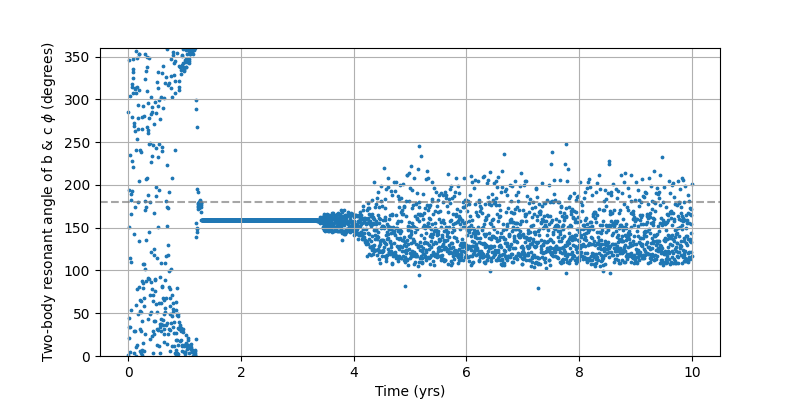

In [ ]:
def last_P(b):
    '''Returns the period value given name of planet'''
    return float(b['a'].iloc[-1]**3 / m_star)**(1/2)

def plot_libration(b, c, d=None, t_units='kyr'):
    b_name = b.attrs["planet_name"]
    c_name = c.attrs["planet_name"]
    
    # 2BR angle
    if d is None:
        print(f"True period ratio: {last_P(c) / last_P(b):.4f}")

        # Calculate two-body resonant angle between b and c
        p, q = find_best_twoBR_pq(b, c)

        assert p != 100 # if not, then the planets are definitely not in resonance
        print(f"p, q: {p}, {q}")
        twoBR = np.rad2deg(twoBR_angle(b, c, p, q))

        plt.figure(figsize=(8,4))
        
        if t_units == 'kyr':
            plt.scatter(stage1_times/1000, twoBR%360, s=3) # mod 360 so it wraps
        plt.axhline(180, color='gray', ls='--', alpha=0.7)
        plt.xlabel("Time (yrs)")
        plt.ylabel(f"Two-body resonant angle of {b_name} & {c_name} $\phi$ (degrees)")
        plt.ylim(0,360)
        plt.grid(True)
        plt.show()
    
    # 3BR angle
    else:
        d_name = d.attrs["planet_name"]
        print(f"True period ratios: b+c: {last_P(c) / last_P(b):.4f}, c+d: {last_P(d) / last_P(c):.4f}")
        
        # Calculate three-body resonant angle between b, c, and d
        p_bc, q_bc, p_cd, q_cd = find_best_threeBR_pq(b, c, d)
        
        assert p_bc != 100; assert p_cd != 100 # if not, then the planets are definitely not in resonance
        print(f"p_{b_name}{c_name}, q_{b_name}{c_name}, p_{c_name}{d_name}, q_{c_name}{d_name}: {p_bc}, {q_bc}, {p_cd}, {q_cd}")
        threeBR = np.rad2deg(threeBR_angle(b, c, d, p_bc, q_bc, p_cd, q_cd))

        plt.figure(figsize=(8,4))
        
        if t_units == 'kyr':
            plt.scatter(stage1_times/1000, threeBR%360, s=3) # mod 360 so it wraps
        plt.axhline(180, color='gray', ls='--', alpha=0.7)
        plt.xlabel("Time (yrs)")
        plt.ylabel(f"Three-body resonant angle of {b_name}, {c_name}, & {d_name} $\phi$ (degrees)")
        plt.ylim(0,360)
        plt.grid(True)
        plt.show()
    
plot_libration(b, c)
# plot_libration(b, c, e)


#### Running Multiple Sims

In [ ]:
N = 5
    
bounds = {
    "m1": (1e-6, 1e-4),
    "m2": (1e-6, 1e-4),
    "m3": (1e-6, 1e-4),
    "m4": (1e-6, 1e-4),
    "m5": (1e-6, 1e-4),
    "m6": (1e-6, 1e-4),
    "m7": (1e-6, 1e-4),
    "PR1": (1.2, 2.5),
    "PR2": (1.2, 2.5),
    "PR3": (1.2, 2.5),
    "PR4": (1.2, 2.5),
    "PR5": (1.2, 2.5),
    "PR6": (1.2, 2.5),
    "K_factor": (1, 100)
}

# param_sets = sample_parameters(N, bounds)

# results = []

# for i, params in enumerate(param_sets):
#     print(f"Running simulation {i+1}/{N}")
#     result = run_simulation(params, sim_id=i)
#     results.append(result)

# save_results(results)